## Import

In [16]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

torch.__version__

'1.13.1+cpu'

In [2]:
pytorch_workflow = {10:'data (prepare and load))', 
                    #torchvision.transforms
                    #torch.utils.data.Dataset
                    #torch.utils.data.DataLoader
                    20:'model (define and initialize)', 
                    21:'loss (define and initialize)', 
                    #torch.nn
                    #torch.nn.Module
                    #torchvision.models
                    22:'optimizer (define and initialize)', 
                    #torch.optim
                    30:'Fit the model', 
                    40:'evaluation (compute loss and accuracy)', 
                    #torchmetrics
                    50:'Improve the model (hyperparameter tuning)', 
                    #torch.utils.tensorboard
                    60:'Save and load the model', 
                    70:'Save and reload the model', 
                    80:'Inference (predict on new data)'}

## 10. Data (prepare and load)

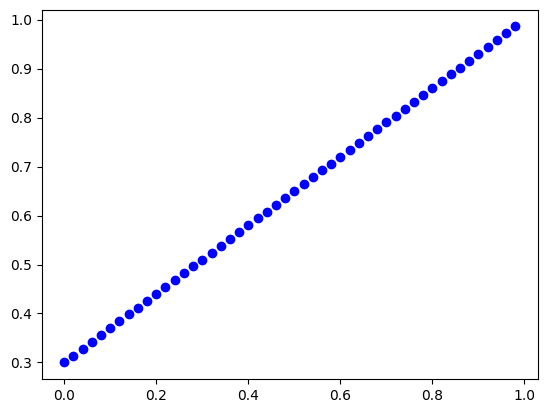

In [6]:
import torch
import matplotlib.pyplot as plt

#Known parameters
weight = 0.7 #slope
bias = 0.3 #intercept

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step)
y = weight * X + bias
plt.plot(X, y, 'bo')

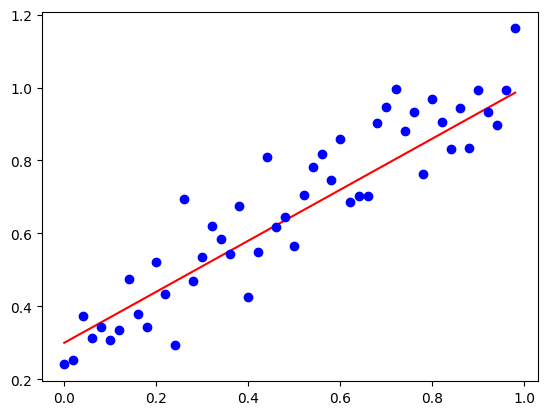

In [7]:
## Add noise
noise = torch.randn(y.shape) * 0.1
y1 = y + noise
plt.plot(X, y, 'r-')
plt.plot(X, y1, 'bo')

In [11]:
# Create train and test data
train_split = int(0.8*len(X))
X_train,y_train = X[:train_split], y1[:train_split]
X_test,y_test = X[train_split:], y1[train_split:]
len(X_train), len(X_test)

(40, 10)

In [12]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14})

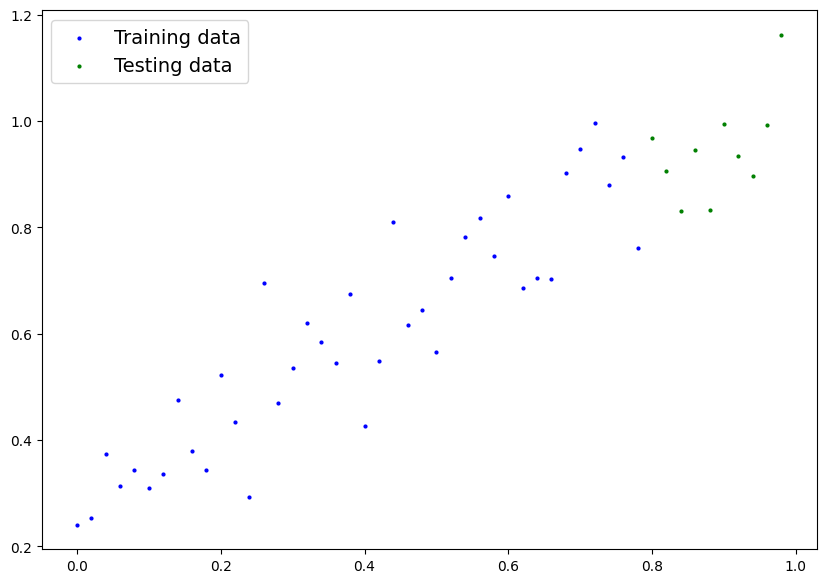

In [13]:
plot_predictions()

## Define the model

In [16]:
# Create a linear regression model class
from torch import nn
class LinearRegressionModel(nn.Module): # Almost everything in pytorch inherits from nn.Module
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, #Starting random weight
                                               dtype = torch.float,
                                               requires_grad = True))
        self.bias = nn.Parameter(torch.randn(1,
                                             dtype = torch.float,
                                             requires_grad = True))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

### Pytorch model building essentials

In [20]:
# Create a random seed to ensure consistency
torch.manual_seed(42)

#Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]